# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cityblock


# Importing dataset and cleaning the data

In [3]:
dataset = pd.read_csv("../input/uber-fares-dataset/uber.csv", na_values=["na", "N/a", np.nan])
dataset.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


### Checking for null values

## dealing with date and time data (extracting year month day and time(hour))

In [4]:
print(dataset.isnull().sum())

dataset[dataset.isnull().any(axis=1)]
#here we also eliminate the row which has passenger count=0

dataset.dropna(axis=0, inplace=True)
dataset.reset_index(drop=True, inplace=True)

print("\n After null value removal \n")
print(dataset.isnull().sum())

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

 After null value removal 

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


# Dropping the invalid latitude and longitudnal values


In [5]:

dataset = dataset[((dataset['pickup_latitude']>=-90) & (dataset['pickup_latitude']<=90)
   & (dataset['dropoff_latitude']>=-90) & (dataset['dropoff_latitude']<=90))
                                          &
     ( (dataset['pickup_longitude']>=-180) & (dataset['pickup_longitude']<=180)
   & (dataset['dropoff_longitude']>=-180) & (dataset['dropoff_longitude']<=180) )]

# as the location lies in ocean
ind_drop = dataset[(dataset['pickup_longitude']>0)& (dataset['pickup_longitude']<10) ].index
dataset.drop(ind_drop, axis=0, inplace=True)
dataset.reset_index(drop=True, inplace=True)
# some values were swapped correcting them
# correcting only pickups coordinates 
count=0
for i in range(len(dataset)):
    if(dataset.iloc[i,4]>0):
        count+=1
        t = dataset.iloc[i,4]
        dataset.iloc[i,4] = dataset.iloc[i,5]
        dataset.iloc[i,5] = t
print(f"{count} rows altered")


# correcting dropoff coordinates    
count=0
for i in range(len(dataset)):
    if(dataset.iloc[i,6]>0):
        count+=1
        t = dataset.iloc[i,6]
        dataset.iloc[i,6] = dataset.iloc[i,7]
        dataset.iloc[i,7] = t
print(f"{count} rows altered")


# additonal drop of all indices which were close to zero

additional_drop  = dataset[((dataset.dropoff_longitude > -10) & (dataset.dropoff_longitude< 10)) & 
        ((dataset.dropoff_latitude > -10) & (dataset.dropoff_latitude< 10))].index

dataset.drop(additional_drop, axis=0, inplace=True)   
dataset.reset_index(drop=True, inplace=True)

#check whether coordinates are same or not
same_cor_ind = dataset[(dataset['pickup_latitude']==dataset['dropoff_latitude']) 
                & (dataset['pickup_longitude']==dataset['dropoff_longitude'])  ].index

dataset.drop(same_cor_ind, axis=0, inplace=True)   
dataset.reset_index(drop=True, inplace=True)


dataset.columns=['Unnamed: 0','key', 'fare_amount', 'pickup_datetime','pickup_latitude',
                 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude','passenger_count']

102 rows altered
104 rows altered


In [6]:
dataset.describe()

,Unnamed: 0,fare_amount,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count
count,1.941670e+05,194167.000000,194167.000000,194167.000000,194167.000000,194167.000000,194167.000000
mean,2.770646e+07,11.349013,-73.893593,40.709100,-73.967338,40.749632,1.684869
std,1.600839e+07,9.740930,2.460152,1.304290,0.714208,0.232087,1.388361
min,1.000000e+00,-52.000000,-93.824668,0.000000,-75.458979,0.737003,0.000000
25%,1.382610e+07,6.000000,-73.992277,40.736396,-73.991602,40.735345,1.000000
50%,2.773233e+07,8.500000,-73.982122,40.753275,-73.980572,40.753756,1.000000
75%,4.153709e+07,12.500000,-73.968423,40.767527,-73.965548,40.768335,2.000000
max,5.542357e+07,499.000000,0.000000,48.018760,0.000000,45.031598,208.000000


# Converting datetime to timestamp type (working on date and time dataset)

In [7]:
dataset['pickup_datetime']=pd.to_datetime(dataset['pickup_datetime'])
dataset['pickup_datetime'].dtype

datetime64[ns, UTC]

In [8]:
def get_corrected_hour(dataset):
    hour=[]

    for i in range(len(dataset)):
        if(dataset.iloc[i,3].minute>30 ):
           hour.append(dataset.iloc[i,3].hour+1)
        elif(dataset.iloc[i,3].minute<=30 and dataset.iloc[i,3].hour!=0 ):
           hour.append(dataset.iloc[i,3].hour)
        else:
           hour.append(23)
        
    return pd.Series(hour, dtype='int32')    
    

dataset['pickup_year'] = pd.Series([ dataset.iloc[i,3].year for i in range(len(dataset))], dtype='int32')
dataset['pickup_day'] = pd.Series([ dataset.iloc[i,3].weekday() for i in range(len(dataset))], dtype='int32')
dataset['pickup_hour'] = get_corrected_hour(dataset)
dataset['pickup_month'] = pd.Series([ dataset.iloc[i,3].month for i in range(len(dataset))], dtype='int32')


dataset.drop(['pickup_datetime'], axis=1, inplace=True)



In [9]:
# manhatten distance between coordinates
def city_block_distance(dataset):
    distance = []
    for i in range(len(dataset)):
        distance.append( '%.3f'%(cityblock((dataset.iloc[i,4], dataset.iloc[i,3]), (dataset.iloc[i,6], dataset.iloc[i,5]) )*100))
    
    return pd.Series(distance, dtype='float32')

dataset['cityblock_travelled'] = city_block_distance(dataset)    

#dropping as distance betweeen them is zero
ind_drop = dataset[(dataset['cityblock_travelled']==0)].index
dataset.drop(ind_drop, axis=0, inplace=True)   
dataset.reset_index(drop=True, inplace=True)


In [10]:
dataset.head(5)

,Unnamed: 0,key,fare_amount,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,pickup_year,pickup_day,pickup_hour,pickup_month,cityblock_travelled
0,24238194,2015-05-07 19:52:06.0000003,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,3,20,5,1.544
1,27835199,2009-07-17 20:04:56.0000002,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,4,20,7,2.245
2,44984355,2009-08-24 21:45:00.00000061,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,0,22,8,7.436
3,25894730,2009-06-26 08:22:21.0000001,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,4,8,6,2.331
4,17610152,2014-08-28 17:47:00.000000188,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,18,8,6.522


In [11]:
dataset[(dataset['pickup_latitude']==dataset['dropoff_latitude']) 
                & (dataset['pickup_longitude']==dataset['dropoff_longitude'])  ]

,Unnamed: 0,key,fare_amount,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,pickup_year,pickup_day,pickup_hour,pickup_month,cityblock_travelled


In [12]:
dataset[(dataset['cityblock_travelled']==0)]

,Unnamed: 0,key,fare_amount,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,pickup_year,pickup_day,pickup_hour,pickup_month,cityblock_travelled


# VISUALIZATION

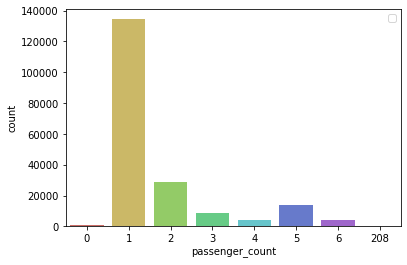

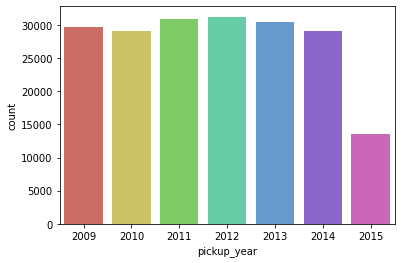

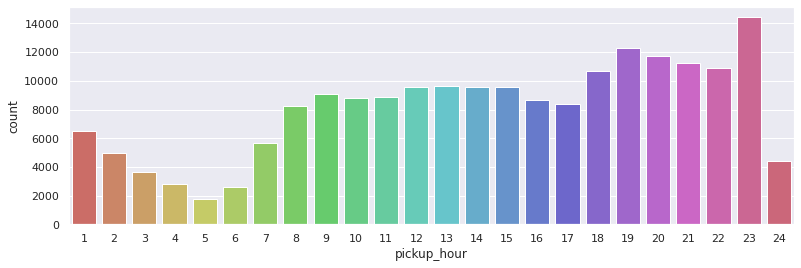

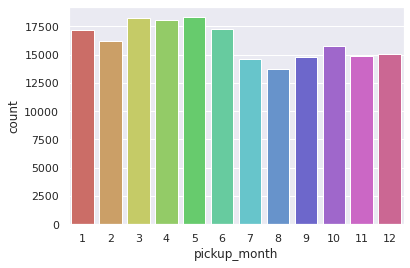

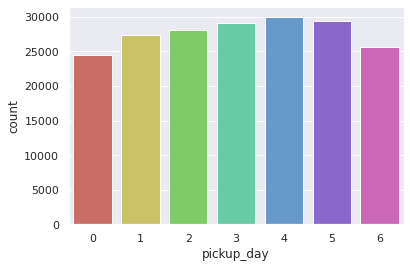

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


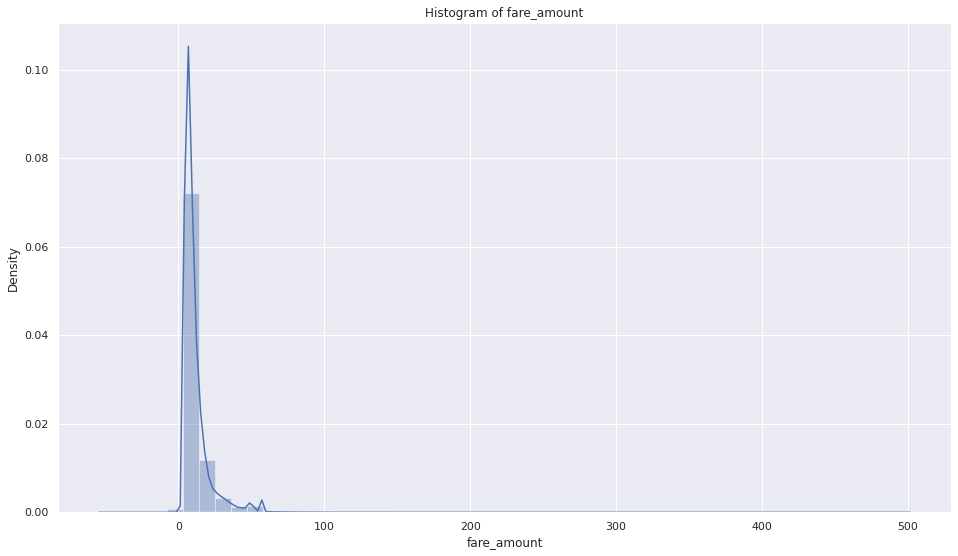

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


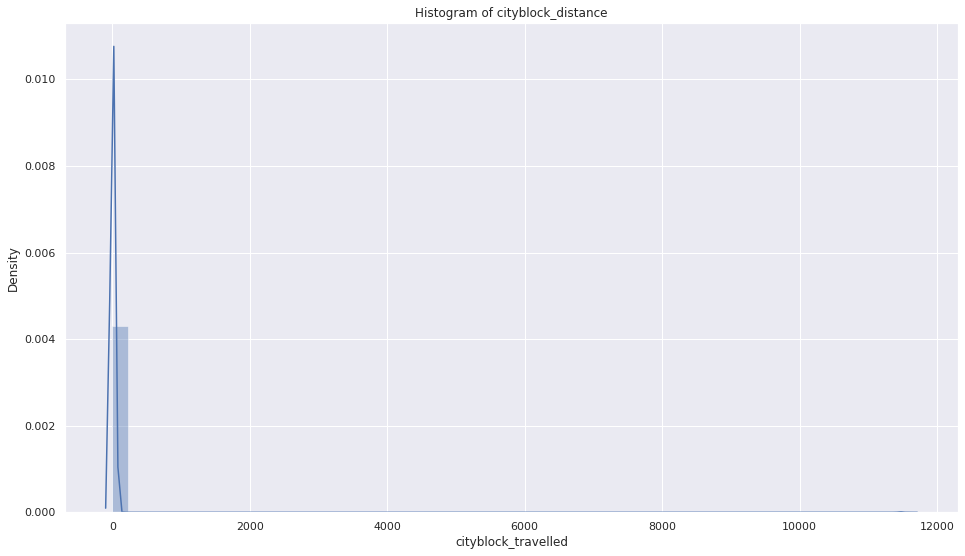

In [13]:
plt.legend()
sns.countplot(x='passenger_count',data=dataset, palette='hls')
plt.show()

sns.countplot(x='pickup_year',data=dataset, palette='hls')
plt.show()

plt.figure(figsize=(13,4)) # figure ration 16:9
sns.set()
sns.countplot(x='pickup_hour',data=dataset, palette='hls')
plt.show()

sns.countplot(x='pickup_month',data=dataset, palette='hls')
plt.show()

sns.countplot(x='pickup_day',data=dataset, palette='hls')
plt.show()


plt.figure(figsize=(16,9)) # figure ration 16:9
sns.set() # for style 

sns.distplot(dataset['fare_amount'],label='fare_amount', bins=50)
 
plt.title("Histogram of fare_amount") # for histogram title
plt.show()

#plotting the distance
plt.figure(figsize=(16,9)) # figure ration 16:9
sns.set() # for style 

sns.distplot(dataset['cityblock_travelled'],label='cityblock_distance', bins=50)
 
plt.title("Histogram of cityblock_distance") # for histogram title
plt.show()


# geoplot to plot the coordinates
#plt.scatter(dataset['pickup_latitude'], dataset['pickup_longitude'],s=2)
#plt.xlabel('pickup_latitude')
#plt.ylabel('pickup_longitude')
#plt.title(' (pickup) latitude vs longitude')
#plt.show()


#plt.scatter(dataset['dropoff_latitude'], dataset['dropoff_longitude'],s=2)
#plt.xlabel('dropoff_latitude')
#plt.ylabel('dropoff_longitude')
#plt.title(' (pickup) latitude vs longitude')
#plt.show()

# Remaining
### get the highest correlated features  drop the inefficient ones
### drop the longitudnal and latitudnla coordinates
### 

# dropping longitude and latitude values

In [15]:
dataset.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)
dataset.describe()

,Unnamed: 0,fare_amount,passenger_count,pickup_year,pickup_day,pickup_hour,pickup_month,cityblock_travelled
count,1.941010e+05,194101.000000,194101.000000,194101.000000,194101.000000,194101.000000,194101.000000,194101.000000
mean,2.770576e+07,11.344442,1.684906,2011.746343,3.048774,14.478710,6.280849,17.762346
std,1.600849e+07,9.723999,1.388402,1.860083,1.946745,6.320481,3.440455,378.697632
min,1.000000e+00,-52.000000,0.000000,2009.000000,0.000000,1.000000,1.000000,0.001000
25%,1.382584e+07,6.000000,1.000000,2010.000000,1.000000,10.000000,3.000000,1.674000
50%,2.772985e+07,8.500000,1.000000,2012.000000,3.000000,15.000000,6.000000,2.850000
75%,4.153618e+07,12.500000,2.000000,2013.000000,5.000000,20.000000,9.000000,5.138000
max,5.542357e+07,499.000000,208.000000,2015.000000,6.000000,24.000000,12.000000,11613.703125


In [16]:
#matter of concern
dataset[(dataset.cityblock_travelled>0)& (dataset.cityblock_travelled<=0.001) ]

,Unnamed: 0,key,fare_amount,passenger_count,pickup_year,pickup_day,pickup_hour,pickup_month,cityblock_travelled
836,28129197,2010-11-04 06:46:41.0000001,5.30,1,2010,3,7,11,0.001
2412,20440498,2009-12-09 15:30:39.0000003,2.50,1,2009,2,15,12,0.001
4231,40972236,2009-09-29 12:50:00.00000096,2.50,5,2009,1,13,9,0.001
9823,20688712,2009-10-08 09:32:33.0000008,45.00,1,2009,3,10,10,0.001
10544,21598108,2011-12-01 19:48:00.000000239,71.00,1,2011,3,20,12,0.001
...,...,...,...,...,...,...,...,...,...
175579,47283846,2011-07-26 10:40:00.00000072,5.00,1,2011,1,11,7,0.001
176988,51879652,2009-08-22 03:20:00.00000060,2.50,1,2009,5,3,8,0.001
182683,21519159,2012-08-17 12:36:08.0000002,165.00,1,2012,4,13,8,0.001
184614,46743836,2014-07-03 06:49:17.0000004,4.00,1,2014,3,7,7,0.001


### cleaning passenger count data (outliers  and getting right value where passengers==0
### cleaning fair amount

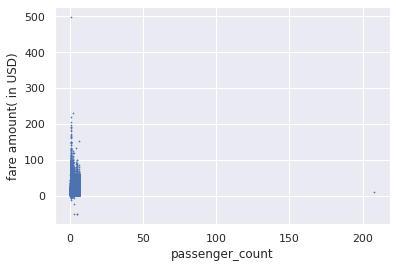

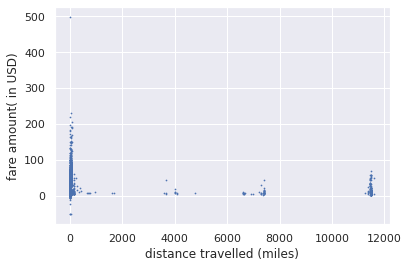

In [17]:
plt.scatter(dataset.passenger_count, dataset.fare_amount, s=0.5 )
plt.xlabel("passenger_count")
plt.ylabel("fare amount( in USD)")
plt.show()

plt.scatter(dataset.cityblock_travelled, dataset.fare_amount, s=0.5 )
plt.xlabel("distance travelled (miles)")
plt.ylabel("fare amount( in USD)")
plt.show()

In [18]:
dataset[(dataset.fare_amount<1)]
# so possibly it can be human error therefore absolute value should replaced with

,Unnamed: 0,key,fare_amount,passenger_count,pickup_year,pickup_day,pickup_hour,pickup_month,cityblock_travelled
21038,46896458,2015-05-31 16:13:41.0000001,0.01,1,2015,6,16,5,0.002
21547,22994576,2010-03-20 02:59:51.0000002,0.00,2,2010,5,3,3,10.381
61549,30260042,2015-03-03 23:07:41.0000008,-5.00,1,2015,1,23,3,0.449
69178,51325304,2010-02-11 21:47:10.0000001,-3.30,2,2010,3,22,2,0.677
77547,50284253,2015-05-01 14:43:02.0000004,-3.50,1,2015,4,15,5,0.409
86690,26673143,2010-03-09 08:26:10.0000006,-49.57,5,2010,1,8,3,0.025
89361,10267585,2010-03-12 08:49:10.0000002,-23.70,3,2010,4,9,3,11.518
95960,51135168,2015-03-20 21:31:14.0000007,-52.00,5,2015,4,22,3,0.539
101005,21688700,2010-03-09 20:25:10.0000002,-7.30,1,2010,1,20,3,1.910
135153,40714150,2010-02-23 18:52:10.0000003,-6.90,1,2010,1,19,2,2.515


In [19]:
#correcting above values
dataset = dataset[(dataset.passenger_count<7)]
dataset.passenger_count.replace(to_replace=0, value=1, inplace=True) # 1 as its the possible mean
dataset['fare_amount'] = abs(dataset['fare_amount'])

## Heatmap to check different correlated features

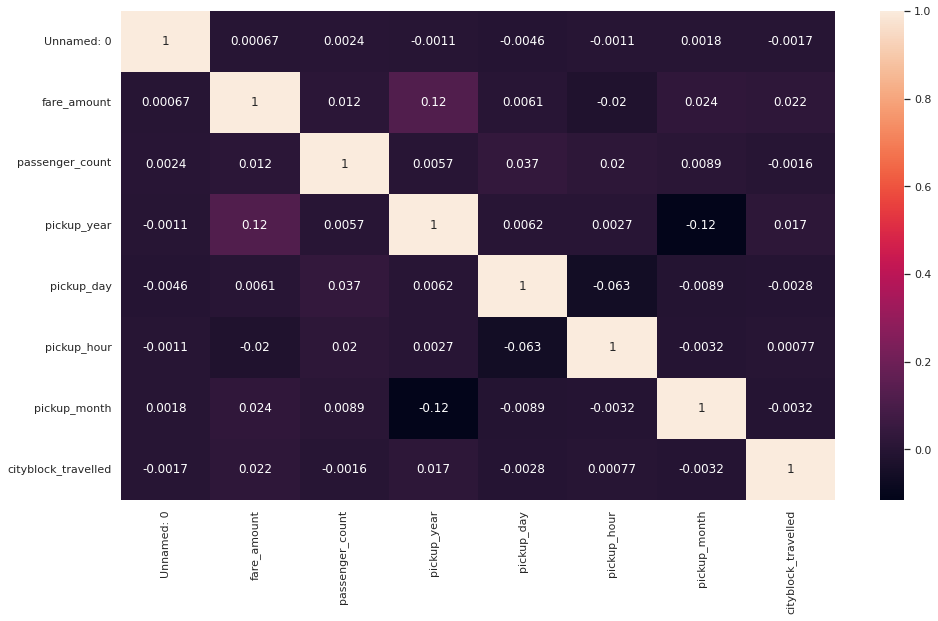

In [20]:
plt.figure(figsize=(16,9))
sns.set()
sns.heatmap(dataset.corr(method='pearson'), annot=True)
plt.show()

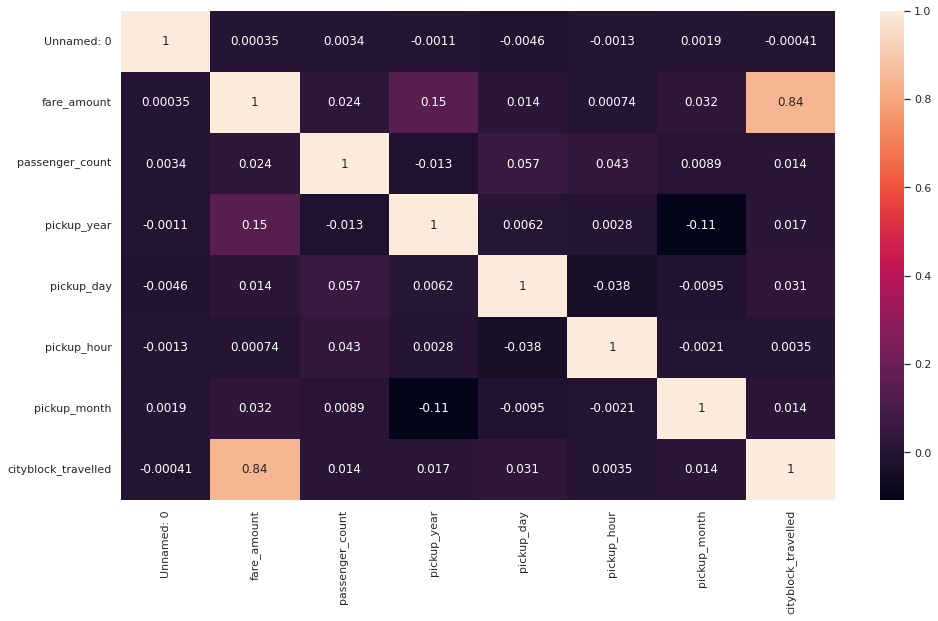

In [21]:
plt.figure(figsize=(16,9))
sns.set()
sns.heatmap(dataset.corr(method='spearman'), annot=True)
plt.show()

In [22]:
# after seeing the heatmap we can remove ['unnamed: 0', 'pickup_hour']  but we spare the pickup hour
dataset.drop(['Unnamed: 0', 'key'], axis=1, inplace=True)


In [ ]:
# coordinates cleaning(invalid cords) and (getting manhatten dist) (removing cords itself)
# extracting usefull information from datetime data
# passenger count cleaning removing outlier values
# cleaning fare amount
# not used outlier detection methods such as IQR, DBSCAN, z-score 

In [ ]:
#saving dataset for future use
dataset.to_csv('./cleaned_fare_data.csv', index=False)

# Model Building part
## data splitting 
## training Ridge and Elastic net algorithms

In [23]:
## spliting
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


## Scaling the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:, :] = sc.fit_transform(X_train[:, :])
X_test[:, :] = sc.transform(X_test[:, :])

(155280, 6) (155280,)
(38820, 6) (38820,)


In [24]:
print(X_train[:2,:])
print(X_test[:2,:])

[[ 0.24063294  0.67473566  1.00368375 -2.13426045  0.50070387 -0.03773299]
 [ 0.24063294 -1.47423272  1.51759906 -0.8676731  -0.37180536 -0.03262892]]
[[ 1.00864827 -0.39974853 -0.02414687 -1.02599652  0.79154028 -0.0439638 ]
 [-0.5273824  -0.39974853 -1.05197749 -1.18431994 -1.24431458 -0.02886967]]


In [25]:
def fit_predict(regressor, train_data, test_data):
    regressor.fit(train_data[0],train_data[1])
    y_pred = regressor.predict(test_data[0])
    return y_pred, regressor

def get_rmse_rscore(y_test, y_pred):
    import sklearn
    import math
    from sklearn.metrics import r2_score
    mse = sklearn. metrics. mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    
    #calculate r-squared
    return rmse, r2_score(y_test,y_pred)
    
    

In [26]:
# applying Ridge Regression
from sklearn.linear_model import Ridge
regressor_LR = Ridge(alpha=1.0, normalize=False)
y_pred, regressor_LR = fit_predict(regressor_LR, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)

print(f"Ridge Regression's RMSE: {rmse}, R-score: {rscore}")

#Linear SVR
from sklearn.svm import LinearSVR
regressor_svr = LinearSVR()
y_pred, regressor_svr = fit_predict(regressor_svr, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)
print(f"Linear SVR's RMSE: {rmse}, R-score: {rscore}")

#decision tree regressor 
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor()
y_pred, regressor_dt = fit_predict(regressor_dt, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)
print(f"DecisionTreeRegressor's RMSE: {rmse}, R-score: {rscore}")




Ridge Regression's RMSE: 9.545123014594909, R-score: 0.018221745093512265
Linear SVR's RMSE: 9.981010743364576, R-score: -0.07349344108196965
DecisionTreeRegressor's RMSE: 6.107450121035591, R-score: 0.5980516901691778


In [27]:
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators=200)
y_pred, regressor_rf = fit_predict(regressor_rf, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)
print(f"RandomForestRegressor's RMSE: {rmse}, R-score: {rscore}")

RandomForestRegressor's RMSE: 4.309196572734563, R-score: 0.799901901922124


In [28]:
from sklearn.ensemble import ExtraTreesRegressor
regressor_et = ExtraTreesRegressor()
y_pred, regressor_et = fit_predict(regressor_et, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)
print(f" AdaBoostRegressor's RMSE: {rmse}, R-score: {rscore}")

 AdaBoostRegressor's RMSE: 4.610387164511756, R-score: 0.7709527171658894


In [29]:
from sklearn.ensemble import AdaBoostRegressor
regressor_adb=AdaBoostRegressor()
y_pred, regressor_adb = fit_predict(regressor_adb, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)
print(f"ExtraTreesRegressor's RMSE: {rmse}, R-score: {rscore}")

ExtraTreesRegressor's RMSE: 28.322422732579227, R-score: -7.643928193937651


# Outlier treatment using IQR

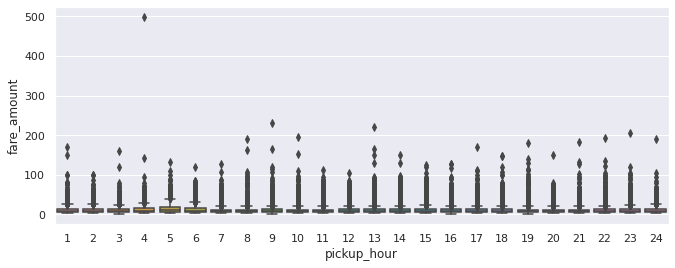

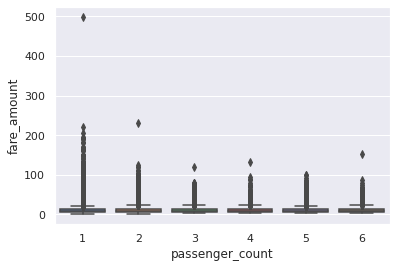

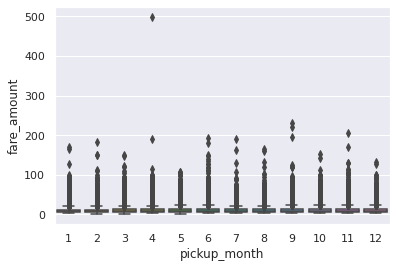

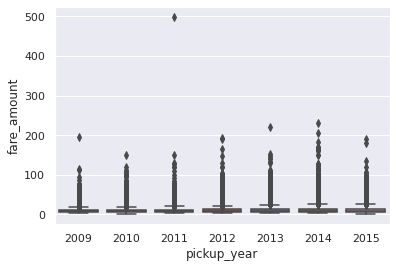

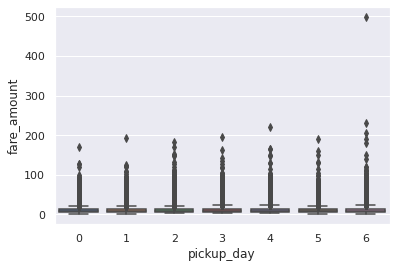

<AxesSubplot:>

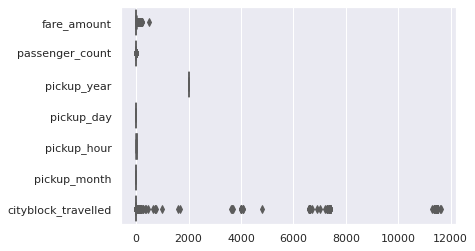

In [30]:
dataset = pd.read_csv('../input/new-data/cleaned_fare_data.csv')
# visualize the outliers using boxplot

plt.figure(figsize=(11,4))
sns.set()
sns.boxplot( x='pickup_hour' ,y='fare_amount', data=dataset)
plt.show()

sns.boxplot( x='passenger_count' ,y='fare_amount', data=dataset)
plt.show()

sns.boxplot( x='pickup_month' ,y='fare_amount', data=dataset)
plt.show()

sns.boxplot( x='pickup_year' ,y='fare_amount', data=dataset)
plt.show()

sns.boxplot( x='pickup_day' ,y='fare_amount', data=dataset)
plt.show()


sns.boxplot(data=dataset, orient="h", palette="hls")

194100
177507
168979


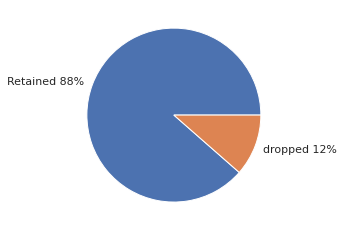

In [31]:
def get_outlier_IQR(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3-q1
    upper = q3 + IQR*1.5
    lower = q1 - IQR*1.5
    outliers = df[(df<lower) | (df>upper)].index # get index numbers of those values
    return outliers


to_drop = get_outlier_IQR(dataset.fare_amount)
print(len(dataset))
train_df = dataset.drop(to_drop, axis=0)
print(len(train_df))
to_drop1 = get_outlier_IQR(train_df.cityblock_travelled)
train_df.drop(to_drop1, axis=0, inplace=True)
print(len(train_df))

drop_per = int((dataset.shape[0] - train_df.shape[0])/dataset.shape[0] *100)


plt.pie([dataset.shape[0], dataset.shape[0] - train_df.shape[0]],labels=[f"Retained {100-drop_per}%",
                                                                          f"dropped {drop_per}%"],
       radius=1)
plt.show()


In [32]:
train_df.columns

Index(['fare_amount', 'passenger_count', 'pickup_year', 'pickup_day',
       'pickup_hour', 'pickup_month', 'cityblock_travelled'],
      dtype='object')

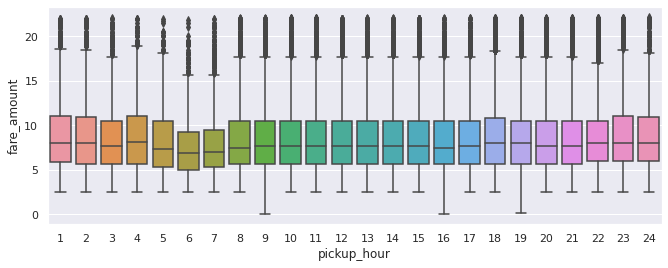

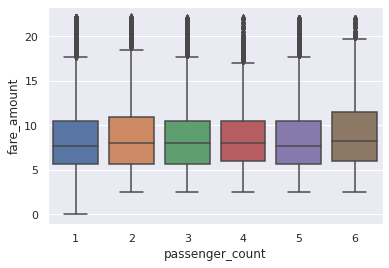

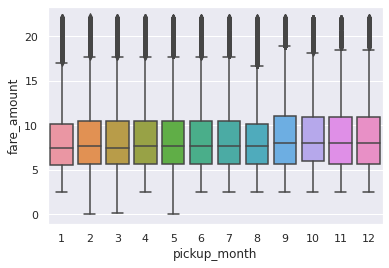

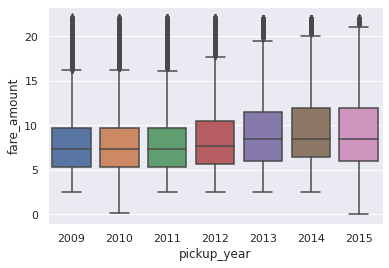

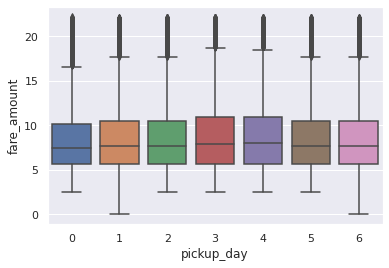

<AxesSubplot:>

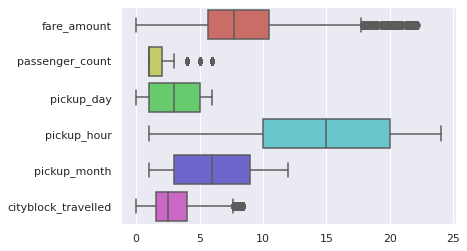

In [33]:
plt.figure(figsize=(11,4))
sns.set()
sns.boxplot( x='pickup_hour' ,y='fare_amount', data=train_df)
plt.show()

sns.boxplot( x='passenger_count' ,y='fare_amount', data=train_df)
plt.show()

sns.boxplot( x='pickup_month' ,y='fare_amount', data=train_df)
plt.show()

sns.boxplot( x='pickup_year' ,y='fare_amount', data=train_df)
plt.show()

sns.boxplot( x='pickup_day' ,y='fare_amount', data=train_df)
plt.show()


sns.boxplot(data=train_df.loc[:,['fare_amount', 'passenger_count', 'pickup_day',
       'pickup_hour', 'pickup_month', 'cityblock_travelled']], orient="h", palette="hls")

# considering data is free from most of outliers

In [34]:
X = train_df.iloc[:, 1:].values
y = train_df.iloc[:, 0].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


## Scaling the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:, :] = sc.fit_transform(X_train[:, :])
X_test[:, :] = sc.transform(X_test[:, :])

(135183, 6) (135183,)
(33796, 6) (33796,)


In [35]:
#ridge regression
from sklearn.linear_model import Ridge
regressor_LR = Ridge(alpha=1., normalize=False)
y_pred, regressor_LR = fit_predict(regressor_LR, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)

print(f"Ridge Regression's RMSE: {rmse}, R-score: {rscore}")


from sklearn.metrics import mean_squared_error
rmse_train = mean_squared_error(y_train, regressor_LR.predict(X_train), squared=False) 
print(f"RMSE on Training data ", rmse_train)
print()

#ELASTIC NET
from sklearn.linear_model import ElasticNet
regressor_en = ElasticNet()
y_pred, regressor_en = fit_predict(regressor_en, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)

print(f"ElasticNet's RMSE: {rmse}, R-score: {rscore}")

from sklearn.metrics import mean_squared_error
rmse_train = mean_squared_error(y_train, regressor_en.predict(X_train), squared=False) 
print(f"RMSE on Training data ", rmse_train)
print()

#Linear SVR
from sklearn.svm import LinearSVR
regressor_svr = LinearSVR()
y_pred, regressor_svr = fit_predict(regressor_svr, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)
print(f"Linear SVR's RMSE: {rmse}, R-score: {rscore}")

from sklearn.metrics import mean_squared_error
rmse_train = mean_squared_error(y_train, regressor_svr.predict(X_train), squared=False) 
print(f"RMSE on Training data ", rmse_train)


from sklearn.linear_model import BayesianRidge
regressor_br = BayesianRidge()
regressor_br = fit_predict(regressor_br, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)
print(f"BayesianRidge's RMSE: {rmse}, R-score: {rscore}")

Ridge Regression's RMSE: 2.2699077890686956, R-score: 0.6287086758052746
RMSE on Training data  2.2602014431924475

ElasticNet's RMSE: 2.6774376114446476, R-score: 0.48342059124562864
RMSE on Training data  2.667687843236182

Linear SVR's RMSE: 2.3131543930799787, R-score: 0.6144261133931642
RMSE on Training data  2.3006690444801436
BayesianRidge's RMSE: 2.3131543930799787, R-score: 0.6144261133931642


In [36]:
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators=500)
y_pred, regressor_rf = fit_predict(regressor_rf, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)
print(f"RandomForestRegressor's RMSE: {rmse}, R-score: {rscore}")

from sklearn.metrics import mean_squared_error
rmse_train = mean_squared_error(y_train, regressor_rf.predict(X_train), squared=False) 
print(f"RMSE on Training data ", rmse_train)


RandomForestRegressor's RMSE: 2.2383354041689145, R-score: 0.6389655043410254
RMSE on Training data  0.8239894931307039


In [37]:
from sklearn.ensemble import ExtraTreesRegressor
regressor_et = ExtraTreesRegressor()
y_pred, regressor_et = fit_predict(regressor_et, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)
print(f" ExtraTreesRegressor's RMSE: {rmse}, R-score: {rscore}")

from sklearn.metrics import mean_squared_error
rmse_train = mean_squared_error(y_train, regressor_et.predict(X_train), squared=False) 
print(f"RMSE on Training data ", rmse_train)

 ExtraTreesRegressor's RMSE: 2.3044209696304017, R-score: 0.6173321218998916
RMSE on Training data  0.06212980831517142


In [38]:
from sklearn.ensemble import AdaBoostRegressor
regressor_adb=AdaBoostRegressor()
y_pred, regressor_adb = fit_predict(regressor_adb, (X_train,y_train), (X_test, y_test))
rmse, rscore = get_rmse_rscore(y_test, y_pred)
print(f"AdaBoostRegressor's RMSE: {rmse}, R-score: {rscore}")

from sklearn.metrics import mean_squared_error
rmse_train = mean_squared_error(y_train, regressor_adb.predict(X_train), squared=False) 
print(f"RMSE on Training data ", rmse_train)

AdaBoostRegressor's RMSE: 2.5171722940504244, R-score: 0.5434122483701187
RMSE on Training data  2.4950435939995983


# Save best model(for further use)

In [40]:
import joblib
filename = 'finalized_model.sav'
filename_scaling = 'scaling_object.sav'
joblib.dump(regressor_rf, filename)
joblib.dump(sc, filename_scaling)


['scaling_object.sav']

# (Temporary)Outlier removal using DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
def get_outliers_DBSCAN(df):
    detector = DBSCAN()
    clusters = detector.fit_predict(df.values.reshape(-1, 1))
    return clusters

to_drop1 = get_outliers_DBSCAN(dataset.iloc[:,0])

print(to_drop1)

In [ ]:
to_drop.append(to_drop1)